<a href="https://colab.research.google.com/github/KNS-Karthik/AITTA/blob/main/3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/KNS-Karthik/AITTA.git

Cloning into 'AITTA'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 579.41 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (7/7), done.


#Data label

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

from google.colab import files
files.upload()

!yolo predict model=yolov8n.pt source="/content/4.jpg"


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
img1 = plt.imread('/content/4.jpg')
plt.imshow(img1)
plt.show


import torch
torch.hub.download_url_to_file('https://ultralytics.com/assets/coco2017val.zip', 'tmp.zip')
!unzip -q tmp.zip -d datasets && rm tmp.zip
!yolo val model=yolov8n.pt data=coco8.yaml

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
img = plt.imread('/content/runs/detect/predict/4.jpg')
plt.imshow(img)
plt.show

#Cat Dog

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5216 - loss: 1.6146 - val_accuracy: 0.5550 - val_loss: 0.6736
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6709 - loss: 0.6226 - val_accuracy: 0.6750 - val_loss: 0.6100


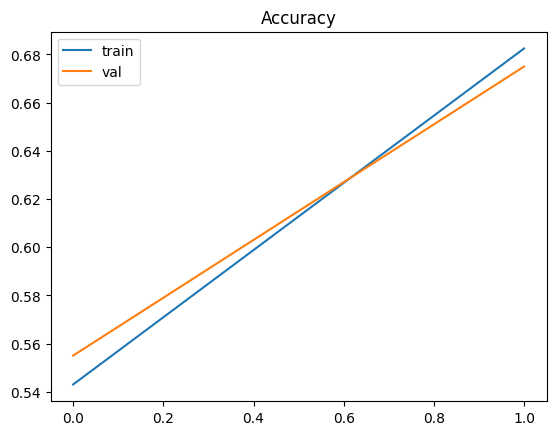

(<matplotlib.legend.Legend at 0x7e2210165d10>,
 Text(0.5, 1.0, 'Accuracy'),
 None)

In [12]:
import os, zipfile, requests, shutil, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Download & extract dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
fname = "cats_and_dogs_filtered.zip"
if not os.path.exists(fname):
    with open(fname, "wb") as f: shutil.copyfileobj(requests.get(url, stream=True).raw, f)
with zipfile.ZipFile(fname, 'r') as zip_ref: zip_ref.extractall()

# Data loaders
gen = ImageDataGenerator(rescale=1./255)
train = gen.flow_from_directory("cats_and_dogs_filtered/train", target_size=(150,150), batch_size=20, class_mode='binary')
val = gen.flow_from_directory("cats_and_dogs_filtered/validation", target_size=(150,150), batch_size=20, class_mode='binary')

# Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train, epochs=2, validation_data=val)

# Plot
plt.plot(hist.history['accuracy'], label='train'), plt.plot(hist.history['val_accuracy'], label='val')
plt.legend(), plt.title("Accuracy"), plt.show()


#NNC

In [3]:
import numpy as np

# Sigmoid function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# Cost function
def compute_cost(y_true, y_pred, Theta1, Theta2, lambda_=0):
    m = len(y_true)
    cost = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    reg = lambda_ / (2 * m) * (np.sum(Theta1[:,1:]*2) + np.sum(Theta2[:,1:]*2))
    return cost + reg

# Input (XOR) data
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

# Add bias term
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# Initialize weights
np.random.seed(0)
Theta1 = np.random.rand(3, 3)  # 3 neurons in hidden layer, 2 inputs + bias
Theta2 = np.random.rand(1, 4)  # 1 output neuron, 3 hidden + bias

# Forward pass
z2 = X_bias @ Theta1.T
a2 = sigmoid(z2)
a2_bias = np.hstack([np.ones((a2.shape[0], 1)), a2])
z3 = a2_bias @ Theta2.T
y_pred = sigmoid(z3)

# Compute unregularized and regularized costs
cost_unreg = compute_cost(y, y_pred, Theta1, Theta2, lambda_=0)
cost_reg = compute_cost(y, y_pred, Theta1, Theta2, lambda_=1)

# Backpropagation (basic version)
d3 = y_pred - y
d2 = d3 @ Theta2[:,1:] * sigmoid_derivative(z2)

Delta1 = d2.T @ X_bias
Delta2 = d3.T @ a2_bias

# Gradients (with and without regularization)
Theta1_grad_unreg = Delta1 / len(y)
Theta2_grad_unreg = Delta2 / len(y)

Theta1_grad_reg = Theta1_grad_unreg.copy()
Theta2_grad_reg = Theta2_grad_unreg.copy()
Theta1_grad_reg[:,1:] += (1 / len(y)) * Theta1[:,1:]
Theta2_grad_reg[:,1:] += (1 / len(y)) * Theta2[:,1:]

# Prediction
predicted = (y_pred >= 0.5).astype(int)

# Output
print("🔹 Unregularized Cost:", round(cost_unreg, 3))
print("🔹 Regularized Cost:  ", round(cost_reg, 3))
print("🔹 Gradients Norm (Unreg):", round(np.linalg.norm(Theta1_grad_unreg), 3))
print("🔹 Gradients Norm (Reg):  ", round(np.linalg.norm(Theta1_grad_reg), 3))

print("\n✅ Predictions (Expected vs Got):")
for i in range(len(X)):
    print(f"Input: {X[i]} → Expected: {y[i][0]} | Got: {predicted[i][0]}")

🔹 Unregularized Cost: 1.05
🔹 Regularized Cost:   2.583
🔹 Gradients Norm (Unreg): 0.074
🔹 Gradients Norm (Reg):   0.479

✅ Predictions (Expected vs Got):
Input: [0 0] → Expected: 0 | Got: 1
Input: [0 1] → Expected: 1 | Got: 1
Input: [1 0] → Expected: 1 | Got: 1
Input: [1 1] → Expected: 0 | Got: 1
